# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [1]:
# Load in the general demographics data.
azdias_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info_df = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [2]:
#Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).


In [3]:
#azdias_df.describe().transpose()

From the above table, it is clear that some of the columns of azdias data set are naturally missing data (ie, white space in the raw data). For example we know there are 891211 persons in the general population data set, so the 'count' values should be 891211 for all the variables,however, we see a count distribution rather than a single value.

Let us try to quantify the  missing  counts.

In [5]:
natMissingData_df=azdias_df.isnull().sum()
print('\nTotally there are' , sum(natMissingData_df), ' naturally missing values.') 
print('This is  roughly ' ,  round((sum(natMissingData_df) *100) /(azdias_df.shape[1]*azdias_df.shape[0]),2), '% of the full azdias data set') 


Totally there are 4896838  naturally missing values.
This is  roughly  6.46 % of the full azdias data set


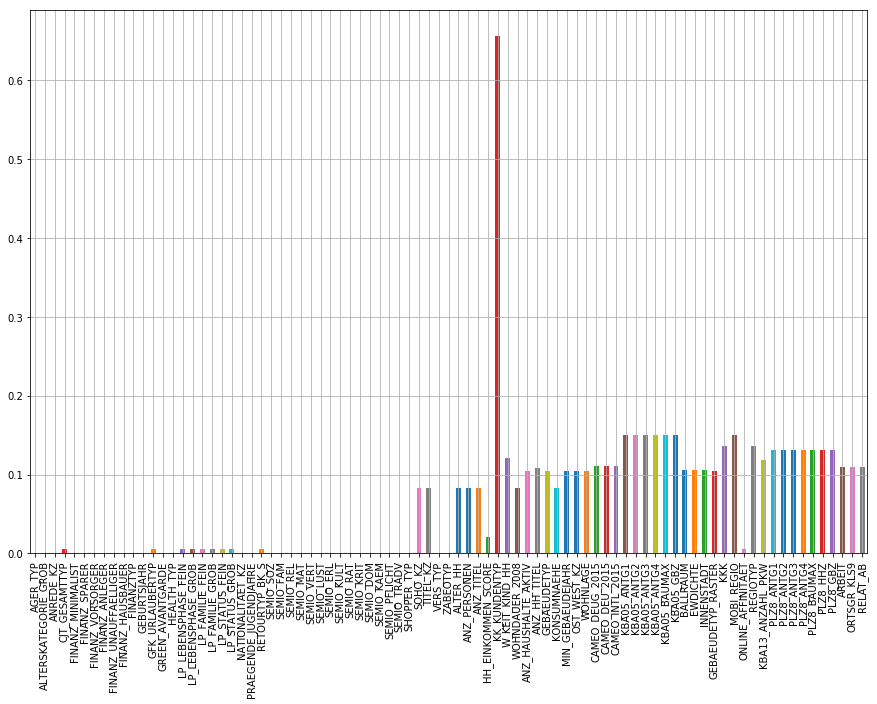

In [6]:
#let us find the percentage of naturally missing data for each columns in azdias data set
var_pcnt=natMissingData_df/azdias_df.shape[0]
var_pcnt.plot.bar(figsize=(15,10),grid=True)

Let us also look at feat_info

In [7]:
#feat_info_df.head(5)
feat_info_df.head(5).append(feat_info_df.tail(5))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
84,RELAT_AB,community,ordinal,"[-1,9]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
#loop thru azdias columns
#loop thru feat_info df, get a list  for missing or unknown values
#replace the corresponding code from azdias data set with nan 
for col in azdias_df.columns:
    print('==> Cleaning up column.......', col)   
    print('Null values before cleaning up:', sum(azdias_df[col].isnull()))   
    missing_string = feat_info_df.loc[feat_info_df.attribute == col, 'missing_or_unknown'].iloc[0]
    #print("missing string is:", missing_string)
    missing_list = missing_string[1:-1].split(',')
    #print("Length of missing string is:", len(missing_list))
    for i in range(len(missing_list)):      
        #print('================================')
        if( missing_list[i].isnumeric() or missing_list[i].lstrip('-').isnumeric() ):
            azdias_df[col].replace(int(missing_list[i]), np.NaN,inplace=True)
            #print('numeric', missing_list[i])
        else :
            #print('nonwhite, nonnumeric ================')
            azdias_df[col].replace(missing_list[i],np.NaN,regex=True,inplace=True)
    print('Null values after cleaning up:', sum(azdias_df[col].isnull()))                   

==> Cleaning up column....... AGER_TYP
Null values before cleaning up: 0
Null values after cleaning up: 685843
==> Cleaning up column....... ALTERSKATEGORIE_GROB
Null values before cleaning up: 0
Null values after cleaning up: 2881
==> Cleaning up column....... ANREDE_KZ
Null values before cleaning up: 0
Null values after cleaning up: 0
==> Cleaning up column....... CJT_GESAMTTYP
Null values before cleaning up: 4854
Null values after cleaning up: 4854
==> Cleaning up column....... FINANZ_MINIMALIST
Null values before cleaning up: 0
Null values after cleaning up: 0
==> Cleaning up column....... FINANZ_SPARER
Null values before cleaning up: 0
Null values after cleaning up: 0
==> Cleaning up column....... FINANZ_VORSORGER
Null values before cleaning up: 0
Null values after cleaning up: 0
==> Cleaning up column....... FINANZ_ANLEGER
Null values before cleaning up: 0
Null values after cleaning up: 0
==> Cleaning up column....... FINANZ_UNAUFFAELLIGER
Null values before cleaning up: 0
Null v

Null values after cleaning up: 133324
==> Cleaning up column....... ONLINE_AFFINITAET
Null values before cleaning up: 4854
Null values after cleaning up: 4854
==> Cleaning up column....... REGIOTYP
Null values before cleaning up: 121196
Null values after cleaning up: 158064
==> Cleaning up column....... KBA13_ANZAHL_PKW
Null values before cleaning up: 105800
Null values after cleaning up: 105800
==> Cleaning up column....... PLZ8_ANTG1
Null values before cleaning up: 116515
Null values after cleaning up: 116515
==> Cleaning up column....... PLZ8_ANTG2
Null values before cleaning up: 116515
Null values after cleaning up: 116515
==> Cleaning up column....... PLZ8_ANTG3
Null values before cleaning up: 116515
Null values after cleaning up: 116515
==> Cleaning up column....... PLZ8_ANTG4
Null values before cleaning up: 116515
Null values after cleaning up: 116515
==> Cleaning up column....... PLZ8_BAUMAX
Null values before cleaning up: 116515
Null values after cleaning up: 116515
==> Cleani

In [9]:
azdias_df.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [10]:
azdias_df.shape

(891221, 85)

In [11]:
aftCleanUpData=sum(azdias_df.isnull().sum())
print("After clean up total number of null values are :", aftCleanUpData) 
print("Number of null values introduced via cleanup procedure:", aftCleanUpData -sum(natMissingData_df))

After clean up total number of null values are : 8373929
Number of null values introduced via cleanup procedure: 3477091


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

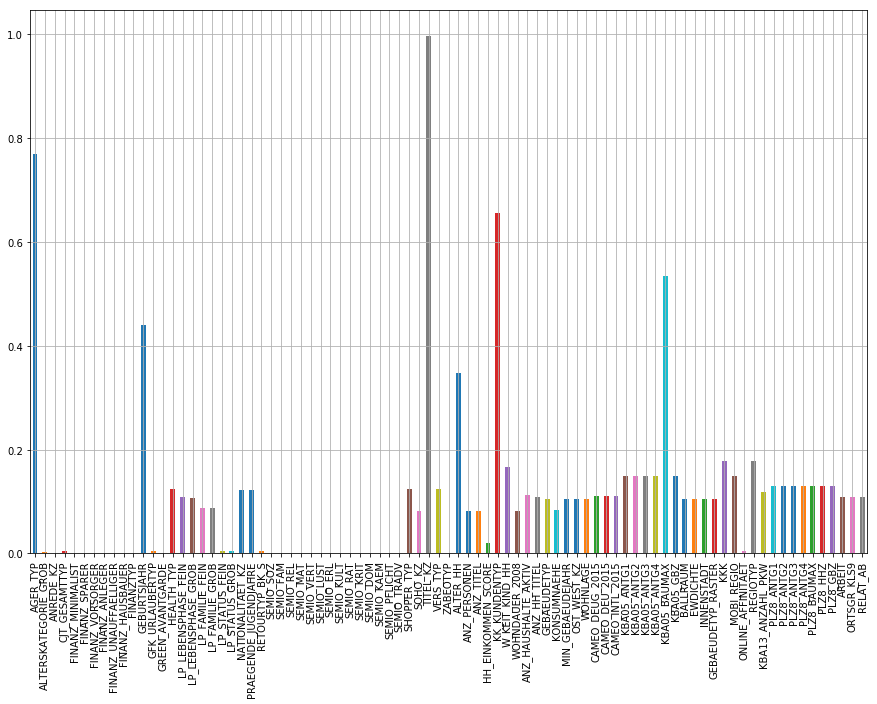

In [12]:
# Perform an assessment of how much missing data there is in each column of the dataset.
#let us find the percentage of  missing data for each columns in cleaned azdias data set
var_pcnt_df=azdias_df.isnull().sum()/azdias_df.shape[0]
#natMissingData.plot.bar(figsize=(15,10),grid=True)
var_pcnt_df.plot.bar(figsize=(15,10),grid=True)

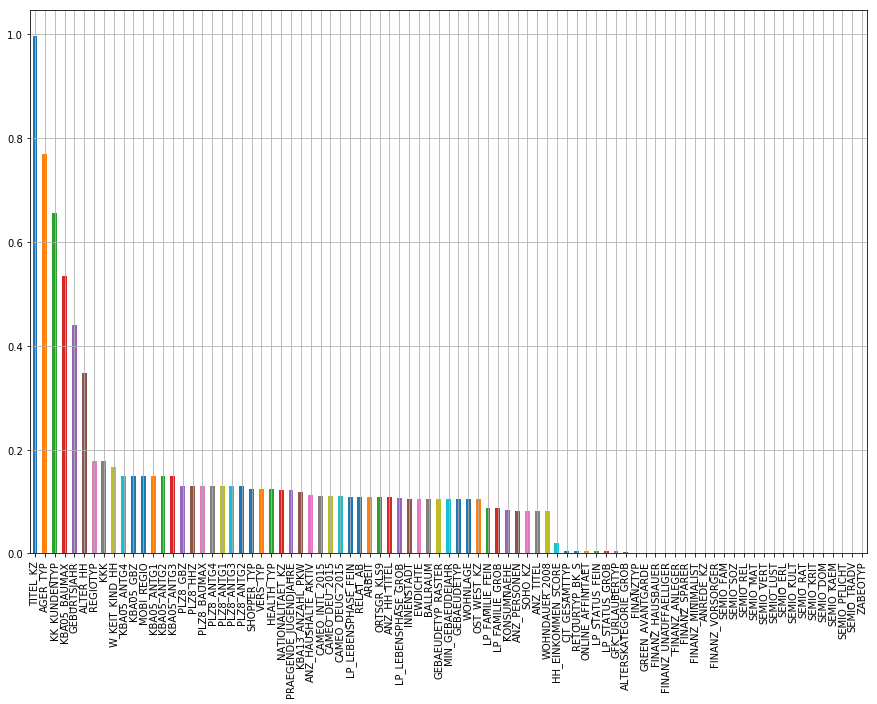

In [13]:
#sort the above information in descending order
var_pcnt_df.sort_values(ascending=False).plot.bar(figsize=(15,10),grid=True)

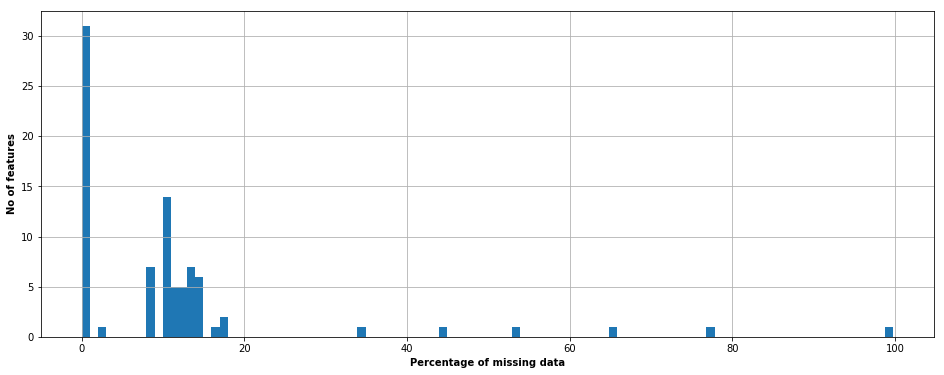

In [14]:
#let us  plot the number of features vs the percentage of missing values
fig = plt.figure(figsize=(16,6))
plt.hist((var_pcnt_df)*100,bins=100)
plt.ylabel('No of features',fontweight='bold')
plt.xlabel('Percentage of missing data',fontweight='bold')
plt.grid(True)

From the above figure, we have a couple of features with more than 20% data missing; which sure looks like outliers. corelating with information with the sorted values of  var_pcnt_df its is clear that which columns are outliers. 

In [15]:
# Remove the outlier columns from the dataset. 
#first we identify the columns to remove
colToDrop = [] #make a list to drop
valcolToDrop = []
threshold=20  #cutoff value
ncol=azdias_df.shape[1]
for col in range(ncol):
    col_i=var_pcnt_df.index[col]
    val_col_i=var_pcnt_df[col]*100
    if val_col_i > threshold:
        colToDrop.append(col_i)
        valcolToDrop.append(val_col_i)
print('\n The following columns will be dropped from further analysis based on the outlier threshold value chosen \n ', colToDrop)
print('\n The corresponding percentage values  are  \n ', valcolToDrop)


 The following columns will be dropped from further analysis based on the outlier threshold value chosen 
  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

 The corresponding percentage values  are  
  [76.95543529607134, 44.02028228688507, 99.75763587258379, 34.81369940789097, 65.59674873011295, 53.468668265222654]


In [16]:
#now drop the columns based on the outlier threshold values
#azdias_df.shape
azdias_df = azdias_df.drop(colToDrop, axis=1)
print(azdias_df.shape)

(891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX columns will be removed based on the threshold chosen (threshold chosen  was supported by our analysis) 

 The corresponding percentage values per feature  of missing data  are  76.95, 44.02, 99.75, 34.81, 65.59, 53.46 respectively


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?
missRow=azdias_df.isnull().sum(axis=1)
missRow

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [18]:
#axis=1 implies we are looking at rows now
#count the number of features missing per row and display up total
missRow_val=azdias_df.isnull().sum(axis=1)

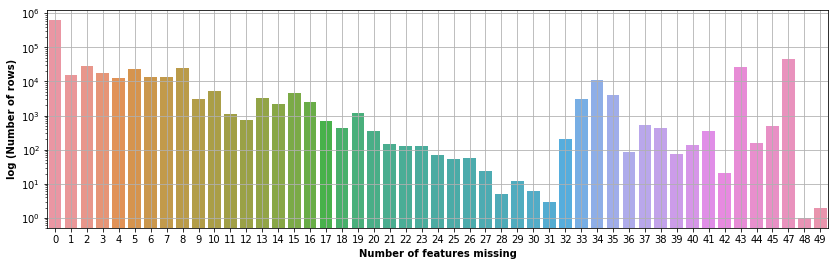

In [19]:
#plot the axis with a log scale, so the lower values are readily visible
plt.figure(figsize=(14,4))
ax=sns.countplot(missRow_val)
ax.set_xlabel('Number of features missing',fontweight='bold')
ax.set_ylabel('log (Number of rows)',fontweight='bold')
ax.set(yscale="log")
plt.grid()

In [20]:
missRow_val.value_counts().sort_index(ascending=True)

0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64

From the above it seems 623209 rows have complete data available (ie, 0 missing features). 15738 rows have a single value missing and so on. From the last part of the above table, 2  rows  are missing 49 features.

Let us take a threshold  value < 10 for the nanHeavy ( means lots of features missing on a given row)  and nanLight data,our aim is to compare two data sets: one  with smaller number of missing features vs another with large missing feature

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#add a new column to the original data set with total number of missing columns in it
azdias_df['nNullFeatures']=azdias_df.isnull().sum(axis=1)
azdias_df.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nNullFeatures
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [22]:
#split the dataframe into  two sets based on the number of missing features in a given column
#then discard the previously added nNullFeatures column
threshold=10
azdias_df_nanHeavy=azdias_df.query('nNullFeatures > 10').drop('nNullFeatures', axis=1) #lots of Nan in this set
azdias_df_nanLight=azdias_df.query('nNullFeatures <= 10').drop('nNullFeatures', axis=1) #


print('Total number of rows in nan heavy data set:', azdias_df_nanHeavy.shape[0])
print('Total number of rows in nan light data set:', azdias_df_nanLight.shape[0])

#remove from nNullFeatures original data set also
azdias_df=azdias_df.drop('nNullFeatures', axis=1) #
print(azdias_df.shape)

Total number of rows in nan heavy data set: 111068
Total number of rows in nan light data set: 780153
(891221, 79)


In [23]:
azdias_df_nanLight.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#get the name of fisrt five columns  with no missing features 
colNames = []
colCounter=0
#Just sample every stepSize column, coulmn selection is arbitrary though note that  if the stepSize  is
#high we may not be able to get 5 distributions with zero missing values for comparison)
stepSize=4 
for i in range(0,azdias_df_nanLight.shape[1],stepSize):
    if(colCounter<5): # we want to compare only 5 distributions
        null_nanLight = azdias_df_nanLight.iloc[:,i].isnull().sum()
        null_nanHeavy = azdias_df_nanHeavy.iloc[:,i].isnull().sum()
        colName = azdias_df_nanLight.iloc[:,i].name
        if(null_nanLight+null_nanHeavy == 0): #this assures there are no features missing on a given row in both sets
            colNames.append(colName)
            colCounter=colCounter+1
            #print(i)
print(colNames)

['FINANZ_SPARER', 'FINANZ_HAUSBAUER', 'SEMIO_REL', 'SEMIO_ERL', 'SEMIO_DOM']


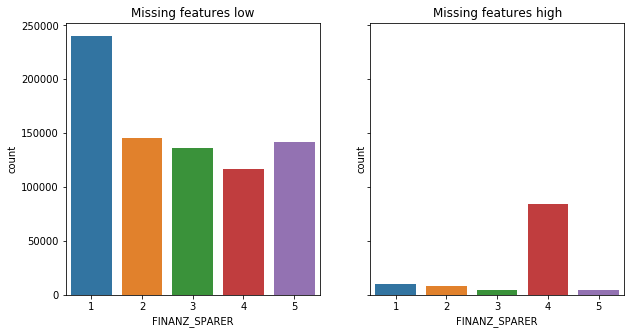

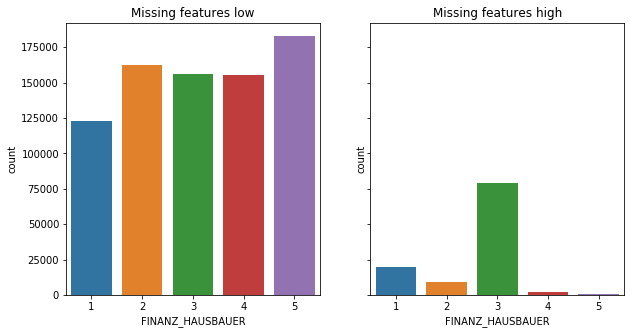

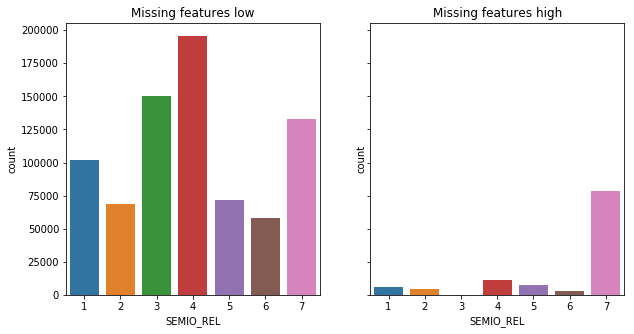

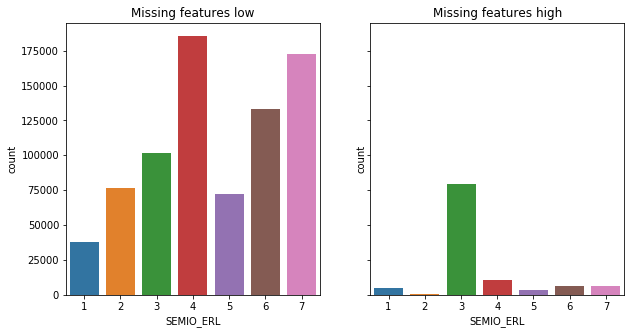

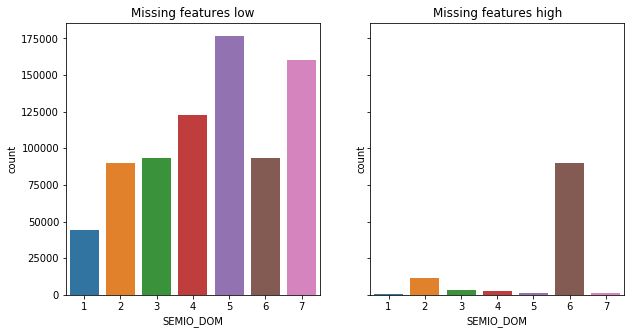

In [25]:
def compareDataSets(column):
    #plt.figure(figsize=(14,4))
    fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(10,5))
    ax1.set_title('Missing features low')
    ax2.set_title('Missing features high')
    sns.countplot(azdias_df_nanLight[column], ax=ax1)
    sns.countplot(azdias_df_nanHeavy[column], ax=ax2)
    plt.show()
for  col in colNames:
    compareDataSets(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

- We did a split of cleaned up dataframe into two dataframes based on the number of missing feature (missing greater than 10 and less than or equal to 10) . Then we sampled a few identical columns from the two different data set with no missing features. From the above graphs, it is clear that there is not a clear pattern in the  count distributions between the nanHeavy and nanLight data sets. 

In [26]:
print(azdias_df.shape)

(891221, 79)


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?
print(feat_info_df['type'].value_counts())

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
#feat_info_df[feat_info_df['type']== 'categorical']
categoricalAtt=feat_info_df[feat_info_df['type'] == 'categorical']['attribute']
#categoricalAtt
#get the above into a array
catVals=categoricalAtt.values
print(catVals)

['AGER_TYP' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'TITEL_KZ'
 'VERS_TYP' 'ZABEOTYP' 'KK_KUNDENTYP' 'GEBAEUDETYP' 'OST_WEST_KZ'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


In [29]:
#However we want only the columns in our cleaned up dataframe 
#(and not from the feature dataframe)
catValCleaned=[]
for col in catVals:
    if col in azdias_df.columns:
        catValCleaned.append(col)
catValCleaned

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [30]:
binCatVal=[]
multiCatVal=[]
for val in catValCleaned:
    if (azdias_df[val].nunique() == 2 ):
        binCatVal.append(val)
    if (azdias_df[val].nunique() > 2 ):
        multiCatVal.append(val)

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
print("Binary categorical variables are", binCatVal)
print("\nMultilevel categorical variables are", multiCatVal)


Binary categorical variables are ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multilevel categorical variables are ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


By comparing at the binary variables with the data dictionary file provied, it looks like OST_WEST_KZ is non-numerical (O and W) and needs to be re-encoded.


In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.
#encode 'OST_WEST_KZ into numerical values
azdias_df['OST_WEST_KZ'] = azdias_df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
azdias_df.shape

(891221, 79)

From the data dictionary, cameo_deu_2015 contains  a more finer scale of the wealth/life style detail, which doesn't add much to the generic analysis. The general behaviour of this column is captured in cameo_deug_2015 varaible. We will drop this multilevel categorical varaible from  further analysis.

In [33]:
dropCol=['CAMEO_DEU_2015']
azdias_df = azdias_df.drop(dropCol,axis=1)
azdias_df.shape

(891221, 78)

In [34]:
#remove CAMEO_DEU_2015 from mutiCatVal variable array, so that we can one hot encode rest of the array
multi=[]
for val in multiCatVal:
    if val not in dropCol:
        multi.append(val)
print("\nFinal multilevel categorical variables to be one hot encoded are ", multi)


Final multilevel categorical variables to be one hot encoded are  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']


In [35]:
#one hot encode 
azdias_df=pd.get_dummies(azdias_df,columns=multi, prefix=multi)
azdias_df.shape

(891221, 150)

In [36]:
azdias_df_1=azdias_df.copy(deep=True)


In [37]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
azdias_df_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ALTERSKATEGORIE_GROB,888340.0,2.757217,1.009951,1.0,2.0,3.0,4.0,4.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0
GREEN_AVANTGARDE,891221.0,0.196612,0.397437,0.0,0.0,0.0,0.0,1.0
HEALTH_TYP,780025.0,2.190129,0.755213,1.0,2.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- The binary categorical variables are 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'. We found that OST_WEST_KZ is a non-numeric binary value,hence we converted this to a numeric binary variable.

- We decided to keep all the multi-level categorical variable except CAMEO_DEU_2015. From the data dictionary, this particular variable contains  a more finer scale of the wealth/life style detail, which doesn't add much to the generic analysis. The  general features of this column are captured in CAMEO_DEUG_2015 variable. 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables

# first let us engineer a new varaible PRAEGENDE_JUGENDJAHRE_MOVEMENT 
# for this purpose with the help of data dictionary we can divide this PRAEGENDE_JUGENDJAHRE in to two;
# code the mainsteam values to 0 and the avantgarde_values to 1

mainstream_values=[1,3,5,8,10,12,14]
avantgarde_values=[2,4,6,7,9,11,13,15]

PRAEGENDE_JUGENDJAHRE_MOVE=[]

for val in azdias_df['PRAEGENDE_JUGENDJAHRE']:
    if val in mainstream_values:
        PRAEGENDE_JUGENDJAHRE_MOVE.append(0)
    elif val in avantgarde_values:
        PRAEGENDE_JUGENDJAHRE_MOVE.append(1)
    else:
        PRAEGENDE_JUGENDJAHRE_MOVE.append(np.nan)
        
#add the PRAEGENDE_JUGENDJAHRE_MOVEMENT to datafarme
azdias_df['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=PRAEGENDE_JUGENDJAHRE_MOVE
azdias_df.shape

(891221, 151)

In [39]:
# now let us engineer a new varaible PRAEGENDE_JUGENDJAHRE_DECADE based on generation
#map the given age intervals  into 6 different categories from the dictionary
#(1 for 1940s, 2 for 1950s, 3 for 1960s, 4 for 1970s, 5 for 1980s and 6 for 1990s)

azdias_df['PRAEGENDE_JUGENDJAHRE_DECADE']=azdias_df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})
azdias_df.shape

(891221, 152)

In [40]:
#now drop the original  PRAEGENDE_JUGENDJAHRE columns
azdias_df = azdias_df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
azdias_df.shape

(891221, 151)

In [41]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#based on wealth and lifestage

#get the  column
col = azdias_df['CAMEO_INTL_2015']

# replace nans to 0, so that we can do manipulations.
col.fillna(0, inplace=True)

WEALTH = col.astype(int) // 10 # get us values from 1 to 5
LIFESTAGE = col.astype(int) % 10 #pick up the modulo (this also goes from 1 to 5 )

# Now put the 0s back to  nan
WEALTH.replace(0,np.nan, inplace=True)
LIFESTAGE.replace(0,np.nan,inplace=True)

azdias_df['CAMEO_INTL_2015_WEALTH'] = WEALTH
azdias_df['CAMEO_INTL_2015_LIFESTAGE'] = LIFESTAGE
azdias_df.drop('CAMEO_INTL_2015', axis=1,inplace=True)
azdias_df.shape

(891221, 152)

In [42]:
#print out the few colums
#azdias_df[:10]

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


- The  variable "PRAEGENDE_JUGENDJAHRE" is re-engineered into PRAEGENDE_JUGENDJAHRE_MOVEMENT and PRAEGENDE_JUGENDJAHRE_DECADE

    - "PRAEGENDE_JUGENDJAHRE_MOVEMENT" : 1 for AVANTGARDE and 0 for MAINSTREAM

    - "PRAEGENDE_JUGENDJAHRE_DECADE" : 1 for 1940s, 2 for 1950s, 3 for 1960s, 4 for 1970s, 5 for 1980s and 6 for 1990s


- The  variable  CAMEO_INTL_2015 is also encoded as CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE

    - "CAMEO_INTL_2015_WEALTH" : 1 for WEALTHY, 2 for PROSPEROUS, 3 for COMFORTABLE, 4 for LESS AFFLUENT and 5 for POORER
    - "CAMEO_INTL_2015_LIFE_STAGE" : 1 for Pre-Family Couples & Singles, 2 for Young Couples With Children, 3 for Families With School Age Children, 4 for Older Families & Mature Couples and 5 for Elders In Retirement.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
azdias_df_2=azdias_df.copy(deep=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
        
    # Identify missing or unknown data values and convert them to NaNs.
    for col in df.columns:
        missing_string = feat_info_df.loc[feat_info_df.attribute == col, 'missing_or_unknown'].iloc[0]
        missing_list = missing_string[1:-1].split(',')
        for i in range(len(missing_list)):      
            #print('================================')
            if( missing_list[i].isnumeric() or missing_list[i].lstrip('-').isnumeric() ):
                df[col].replace(int(missing_list[i]), np.NaN,inplace=True)
            else :
                df[col].replace(missing_list[i],np.NaN,regex=True,inplace=True)
                  
    #===========================================================================================
    #drop columns
    colToDrop=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(colToDrop, axis=1)
    
    #===========================================================================================
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    
    
    dropCol=['CAMEO_DEU_2015']
    df = df.drop(dropCol,axis=1)
    
    multi=['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
    df=pd.get_dummies(df,columns=multi, prefix=multi)
    
    mainstream_values=[1,3,5,8,10,12,14]
    avantgarde_values=[2,4,6,7,9,11,13,15]

    PRAEGENDE_JUGENDJAHRE_MOVE=[]

    for val in df['PRAEGENDE_JUGENDJAHRE']:
        if val in mainstream_values:
            PRAEGENDE_JUGENDJAHRE_MOVE.append(0)
        elif val in avantgarde_values:
            PRAEGENDE_JUGENDJAHRE_MOVE.append(1)
        else:
            PRAEGENDE_JUGENDJAHRE_MOVE.append(np.nan)
        
    #add the PRAEGENDE_JUGENDJAHRE_MOVEMENT to datafarme
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=PRAEGENDE_JUGENDJAHRE_MOVE
    df['PRAEGENDE_JUGENDJAHRE_DECADE']=df['PRAEGENDE_JUGENDJAHRE'].map({1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6})
    df = df.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    
    col = df['CAMEO_INTL_2015']
    col.fillna(0, inplace=True)
    WEALTH = col.astype(int) // 10 # get us values from 1 to 5
    LIFESTAGE = col.astype(int) % 10 #pick up the modulo (this alos goes from 1 to 5 )
    WEALTH.replace(0,np.nan, inplace=True)
    LIFESTAGE.replace(0,np.nan,inplace=True)
    df['CAMEO_INTL_2015_WEALTH'] = WEALTH
    df['CAMEO_INTL_2015_LIFESTAGE'] = LIFESTAGE
    df.drop('CAMEO_INTL_2015', axis=1,inplace=True)
    
    
    # Return the cleaned dataframe.
    print('\tShape of df from the function call=: ',df.shape)
    return df

In [45]:
##do a sanity check of the above cleanup function
azdias_check_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

In [46]:
azdiasCleaned_df=clean_data(azdias_check_df)
print("\tShape of original set after manual engineering steps:", azdias_df.shape )
#Both shapes should be same

	Shape of df from the function call=:  (891221, 152)
	Shape of original set after manual engineering steps: (891221, 152)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [47]:
# Apply feature scaling to the general population demographics data.

#First impute Nan
#impute all variables using most frequently occuring values (a lot if the nans are categorical or binary)
#if continuos then mean would be more appropritae

imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
#azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_low),   index=azdias_low.index, columns=azdias_low.columns)
azdias_imputed_df = imputer.fit_transform(azdiasCleaned_df)
azdias_imputed_df = pd.DataFrame(azdias_imputed_df)
#give columns and index from old DF 
azdias_imputed_df.columns = azdiasCleaned_df.columns
azdias_imputed_df.index = azdiasCleaned_df.index
azdias_imputed_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,0.0,3.0,15.0,4.0,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,0.0,2.0,1.0,0.0,2.0,6.0,9.0,1.0,0.0,1.0,1992.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,6.0,6.0,5.0,4.0,3.0,1.0,1.0,6.0,1400.0,2.0,3.0,2.0,0.0,1.0,3.0,3.0,4.0,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,1.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,21.0,6.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,1.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0

In [48]:
#check the sum of remaining null , should be 0
print("Total null values remaining after imputing:", azdias_imputed_df.isnull().sum().sum())

Total null values remaining after imputing: 0


In [49]:
# Now feature scaling.
scaler = StandardScaler()
azdias_imputedScaled_df = scaler.fit_transform(azdias_imputed_df)
azdias_imputedScaled_df= pd.DataFrame(azdias_imputedScaled_df)
#give columns and index from old DF 
azdias_imputedScaled_df.columns = azdias_imputed_df.columns
azdias_imputedScaled_df.index = azdias_imputed_df.index
azdias_imputedScaled_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,-0.751680,-1.045218,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.494701,0.938197,0.027784,-0.175324,1.107928,-0.999639,0.901553,1.374629,0.537487,-1.455284,0.316841,-0.819565,-0.538400,0.056863,1.221756,0.742018,0.839442,0.420264,-0.387544,-0.088255,0.864739,-0.593390,-0.057885,-1.379075,0.873364,0.536436,-0.436907,-0.118316,-1.167350,-0.359845,0.482932,-0.503428,-0.907602,-0.872303,-0.552796,-0.434299,-0.109875,0.771572,1.056974,0.209499,0.267123,0.254254,-1.118995,-1.116346,0.712197,1.689863,-0.241920,0.200128,0.378140,-0.846764,-0.587083,-0.572015,-0.317206,0.758890,-0.120115,-0.049267,-0.353241,2.233739,-0.461435,-0.556886,-0.389460,-0.456895,-0.537164,-0.376925,-0.252346,2.413036,-0.368272,-0.695167,-0.252964,-0.23516,-0.258954,-0.277611,-0.394698,-0.177219,-0.225033,-0.331084,-0.27014,2.677092,-0.313472,-0.429034,-0.957735,2.746703,-0.074795,-0.118313,-0.116431,-0.101127,-0.154318,-0.162877,-0.112548,-0.427874,-0.248207,-0.957735,2.746703,-0.183987,-0.250909,-0.539258,1.750542,-0.391101,-0.301149,-0.31039,-0.302008,-0.189562,-0.106844,-0.150378,-0.437606,-0.390693,1.280847,-0.58445,-0.219521,-0.473014,-0.390693,-1.817303,-0.281456,-0.197331,-0.408743,-0.632675,-0.550832,-0.520916,-0.401311,-0.196615,1.200973,-0.555385,-0.324607,-0.301964,-1.033910,-0.07462,-0.500743,-0.031794,-0.001059,-0.026555,-0.454311,-0.205798,-0.320952,-0.328443,-0.363296,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684,-0.494701,0.994991,1.039938,-1.095866
1,-1.743339,0.956738,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-0.494701,0.938197,0.507572,0.3

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)


- We imputed using most_frequent value  since most of the null values are categorical or binary in nature. Usng median or mean doesn't make sense for thos type of data.

- We used StandardScaler for feature scaling, by default it uses mean=0 and std deviation as 1


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
# Apply PCA to the data.
pca = PCA(random_state=42)
azdias_imputedScaledPCAfull = pca.fit_transform(azdias_imputedScaled_df)

In [51]:
# From the lab program use a tweaked version of  scree_plot
# Investigate the variance accounted for by each principal component.

def scree_plot(pca,numCompToPlot):
    '''
    Creates a scree plot associated with the principal components 
    INPUT: pca - the result of an instance of PCA in scikit learn
          numCompToPlot - number of components to display for second plot
    '''
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        if(i%20==0):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    plt.grid()
    ax.set_xlabel("Principal Component", fontweight='bold')
    ax.set_ylabel("Variance Explained (%)",fontweight='bold')
    plt.title('Explained Variance Per Principal Component')
    
    print('\tCumulative variance explained with first 15 components: {}'.format(cumvals[14]))
    print('\tCumulative variance explained with first 30 components: {}'.format(cumvals[29]))
    print('\tCumulative variance explained with first 50 components: {}'.format(cumvals[49]))
    plt.show()
    
    #=====Now plot a zoomed in version of above plot
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.bar(ind[:numCompToPlot], vals[:numCompToPlot])
    ax.plot(ind[:numCompToPlot], cumvals[:numCompToPlot])
    ax.xaxis.set_tick_params(width=0)
    for i in range(num_components):
        #if(i%10==0):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    
    ax.yaxis.set_tick_params(width=2, length=12)
 
    plt.grid()
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component (zoomed)')    

	Cumulative variance explained with first 15 components: 0.45248447328339275
	Cumulative variance explained with first 30 components: 0.5939142878864917
	Cumulative variance explained with first 50 components: 0.7374398936233073


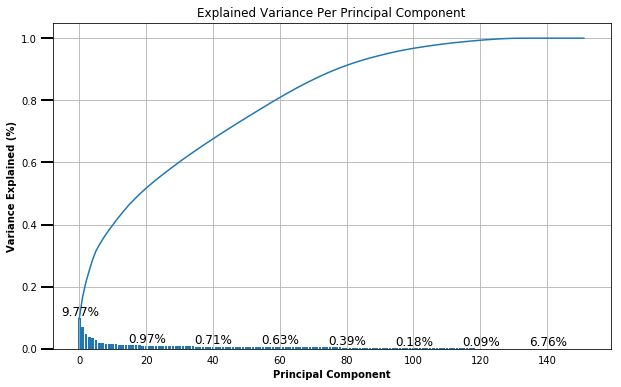

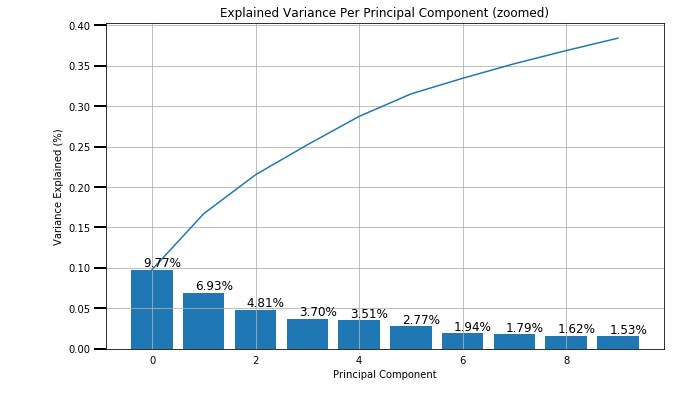

In [52]:
#second argument is  number of components to display on second plot
scree_plot(pca,10)

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=30,random_state=42)
azdias_imputedScaledPCA = pca.fit_transform(azdias_imputedScaled_df)
#azdias_imputedScaledPCA

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

- The first PCA component explain about 9.7 % of the data, first 5 features capture more than 30 %. We will keep first 30 components (out of 152 features) moving forward. This choice essentially explains about 59% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
#just check the first PCA component
#pca.components_[0]

In [55]:
def analysePrincipalComponents(pca, component, nfeatures, feature_names):
    '''
    input:pca the result of an instance of PCA in scikit learn
         component: pca component to analyse
         nfeatures: number of features to analyse for the given Principal component
         feature_names: column with feature names
    '''
    if(component <= len(pca.components_)):
        #for component in range(ncomponent):
            #first make a DF with weight and feature names of this particular component
            pca_weightfeature_df = pd.DataFrame({'name': feature_names,'weight': pca.components_[component]})
            #sort the above DF
            pca_weightfeature_df= pca_weightfeature_df.sort_values(by='weight', ascending=False)
            print('\n ========Analysing principal Component {} ==========================\n'.format(component))
            print('Highest {0} positive weights  for component {1} \n {2}'.format(nfeatures, component,pca_weightfeature_df.head(nfeatures)))
            print('\nHighest {0} negative weights  for component {1} \n {2} \n'.format(nfeatures, component, pca_weightfeature_df.tail(nfeatures)))  
    else:
        print('Error: component out of range')

In [56]:
#Map weights principal components to corresponding feature names
#and then print the linked values, sorted by weight.
#First principal component 
componentNumber=0
analysePrincipalComponents(pca, componentNumber, 5, azdias_imputed_df.columns)    


 ========Analysing principal Component 0 ==========================

Highest 5 positive weights  for component 0 
                        name    weight
56               PLZ8_ANTG3  0.181413
150  CAMEO_INTL_2015_WEALTH  0.177911
114      LP_STATUS_GROB_1.0  0.177563
46                 EWDICHTE  0.157369
58              PLZ8_BAUMAX  0.153590

Highest 5 negative weights  for component 0 
                  name    weight
44          KBA05_GBZ -0.176640
54         PLZ8_ANTG1 -0.180521
40        KBA05_ANTG1 -0.180857
50         MOBI_REGIO -0.186708
2   FINANZ_MINIMALIST -0.192528 



In [57]:
#Second principal component 
componentNumber=1
analysePrincipalComponents(pca, componentNumber, 5, azdias_imputed_df.columns)   


 ========Analysing principal Component 1 ==========================

Highest 5 positive weights  for component 1 
                      name    weight
0    ALTERSKATEGORIE_GROB  0.224788
4        FINANZ_VORSORGER  0.215855
19              SEMIO_ERL  0.174214
12         RETOURTYP_BK_S  0.157038
128            ZABEOTYP_3  0.150004

Highest 5 negative weights  for component 1 
                              name    weight
15                      SEMIO_REL -0.211546
5                  FINANZ_ANLEGER -0.218664
6           FINANZ_UNAUFFAELLIGER -0.221982
3                   FINANZ_SPARER -0.227987
149  PRAEGENDE_JUGENDJAHRE_DECADE -0.234466 



In [58]:
#Third principal component 
componentNumber=2
analysePrincipalComponents(pca, componentNumber, 5, azdias_imputed_df.columns)   


 ========Analysing principal Component 2 ==========================

Highest 5 positive weights  for component 2 
           name    weight
17  SEMIO_VERT  0.288138
13   SEMIO_SOZ  0.259142
20  SEMIO_KULT  0.259106
14   SEMIO_FAM  0.148700
57  PLZ8_ANTG4  0.128635

Highest 5 negative weights  for component 2 
            name    weight
128  ZABEOTYP_3 -0.175034
1     ANREDE_KZ -0.232165
23    SEMIO_DOM -0.236194
24   SEMIO_KAEM -0.265662
22   SEMIO_KRIT -0.277794 



### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

- As mentioned earlier the first principal component (PC 1) explain about 9.7 %, second one about 6.9 % and third about 4.8%. 

For a given PC, features with larger weights have more importance

- The first 5 highest positive weights and their  corresponding features  for PC 1 are 
    - PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region ) =>0.181413
    - CAMEO_INTL_2015_WEALTH (  this is a variable we encoded based on wealth/LifeStage ) => 0.177912
    - LP_STATUS_GROB_1.0  (again we encoded this variable, based on social status_low income earners) => 0.177563
    - EWDICHTE (density of households per square kilometer) => 0.157369
    - PLZ8_BAUMAX (Most common building type within the PLZ8 region)=> 0.153591
        
- The last 5 negative weights and their  corresponding features  for PC 1 are  
    - KBA05_GBZ (Number of buildings in the microcell)             => -0.176640
    - PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region ) => -0.180521
    - KBA05_ANTG1 (Number of 1-2 family houses in the microcell )  => -0.180857
    - MOBI_REGIO (Movement patterns)                               => -0.186708
    - FINANZ_MINIMALIST (low financial interest)                   => -0.192528 

#### This imples that the most important factors in PC 1 are densely populated in the PLZ8 region; wealth is an important variable ( low_income earners are favored) who seems to live in 6-10 family houses.        

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [59]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

cluster_range = [2,6,10,14,18,25]
model_score = []  
for i in cluster_range:
    print("Working with {} clusters on reduced PC set....".format(i))
    kmeans = KMeans(n_clusters=i,random_state=42)
    model = kmeans.fit(azdias_imputedScaledPCA)
    score = np.abs(model.score(azdias_imputedScaledPCA))  
    model_score.append(score)
print(model_score)   

Working with 2 clusters on reduced PC set....
Working with 6 clusters on reduced PC set....
Working with 10 clusters on reduced PC set....
Working with 14 clusters on reduced PC set....
Working with 18 clusters on reduced PC set....
Working with 25 clusters on reduced PC set....
[69979372.92905962, 54912517.867472745, 49533742.56063119, 45792139.41199685, 43099154.31509074, 40344789.68107055]


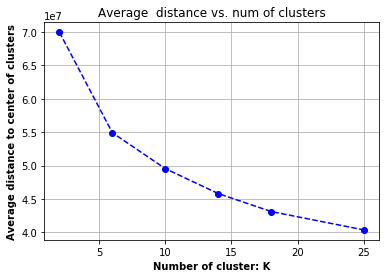

In [60]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_range, model_score, linestyle='--', marker='o', color='b');
plt.xlabel('Number of cluster: K',fontweight='bold');
plt.ylabel('Average distance to center of clusters',fontweight='bold');
plt.title('Average  distance vs. num of clusters');
plt.grid()
plt.show()

In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans10 = KMeans(n_clusters=10,random_state=42)
genPopulation_clusters = kmeans10.fit_predict(azdias_imputedScaledPCA)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

- We couldn't find a well defined elbow to select the number of clusters. However, the rate of change in slope is considerably different for the curve around x axis ~ 10.  Let us chose 10 clusters to segment the population since further addition of the clusters doesn't seem to be beneficial.
    
    

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [62]:
# Load in the customer demographics data
customers_df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
#make sure we have same number of columns as the original general population data
print(customers_df.shape)

(191652, 85)


In [63]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_dfFrom_cleandata=clean_data(customers_df)

#compare  customer df with  with gen pop data
for column in azdias_df.columns:
    if column not in customer_dfFrom_cleandata.columns:
        print("The following columns are missing from customer data set after cleaning:",column)

	Shape of df from the function call=:  (191652, 151)
The following columns are missing from customer data set after cleaning: GEBAEUDETYP_5.0


GEBAEUDETYP is building type, make a column and fill with 0 (ie,  unknown value -> from data dictionary)

In [64]:
customer_dfFrom_cleandata['GEBAEUDETYP_5.0'] = 0
customer_dfFrom_cleandata.shape

(191652, 152)

In [65]:
#use the same imputer we used for gen population on customer data

customer_imputed_df = imputer.fit_transform(customer_dfFrom_cleandata)
customer_imputed_df = pd.DataFrame(customer_imputed_df)
#give columns and index from old DF 
customer_imputed_df.columns = customer_dfFrom_cleandata.columns
customer_imputed_df.index = customer_dfFrom_cleandata.index


In [66]:
#use the same scaler we used for gen population on customer data

customer_imputedScaled_df = scaler.fit_transform(customer_imputed_df)
customer_imputedScaled_df = pd.DataFrame(customer_imputedScaled_df)
#give columns and index from old DF 
customer_imputedScaled_df.columns = customer_imputed_df.columns
customer_imputedScaled_df.index = customer_imputed_df.index

In [67]:
#use the same PCA transformation  we used for gen population on customer data
# with PCA(n_components=30)
customer_imputedScaledPCA= pca.fit_transform(customer_imputedScaled_df)

In [68]:
#use the same  clustering prediction for gen population on customer data
customer_clusters = kmeans10.fit_predict(customer_imputedScaledPCA)

In [69]:
customer_clusters.shape

(191652,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [70]:
def getSegmentCounts(clusterName):
    in_df=pd.Series(clusterName) #convert to a DF
    count=in_df.value_counts().sort_index()
    return count

In [71]:
customerCounts=getSegmentCounts(customer_clusters)
genPopCounts=getSegmentCounts(genPopulation_clusters)
print(customerCounts)
print("\t Total counts in customer segment considered: ", customerCounts.sum())
print("=====================")
print(genPopCounts)
print(genPopCounts.sum())
print("\t Total counts in gen population segment considered: ",genPopCounts.sum())


0    46757
1    19611
2    12601
3    14143
4    26445
5    18421
6    26709
7     1602
8     8219
9    17144
dtype: int64
	 Total counts in customer segment considered:  191652
0    116253
1     44603
2     97181
3    114698
4    115971
5    126312
6     73832
7     80042
8     28820
9     93509
dtype: int64
891221
	 Total counts in gen population segment considered:  891221


In [72]:
#create a data frame with cluster counts (and normalised counnts)
#of both general population and customers 
genPcnt=genPopCounts*100/genPopCounts.sum()
cusPcnt=customerCounts*100/customerCounts.sum()
diffPcnt=genPcnt-cusPcnt #percent difference
df=pd.concat([genPopCounts,customerCounts,genPcnt,cusPcnt,diffPcnt], axis=1)
df=df.reset_index() #add cluster index as a column
df.columns = ['cluster','genPop','customer','genPopPcnt','custPcnt','genMinusCusPcnt']
df

,cluster,genPop,customer,genPopPcnt,custPcnt,genMinusCusPcnt
0,0,116253,46757,13.044239,24.396823,-11.352584
1,1,44603,19611,5.004707,10.232609,-5.227902
2,2,97181,12601,10.904254,6.574938,4.329316
3,3,114698,14143,12.869760,7.379521,5.490238
4,4,115971,26445,13.012597,13.798447,-0.785850
5,5,126312,18421,14.172916,9.611692,4.561224
6,6,73832,26709,8.284365,13.936197,-5.651832
7,7,80042,1602,8.981162,0.835890,8.145272
8,8,28820,8219,3.233766,4.288502,-1.054736
9,9,93509,17144,10.492235,8.945380,1.546855


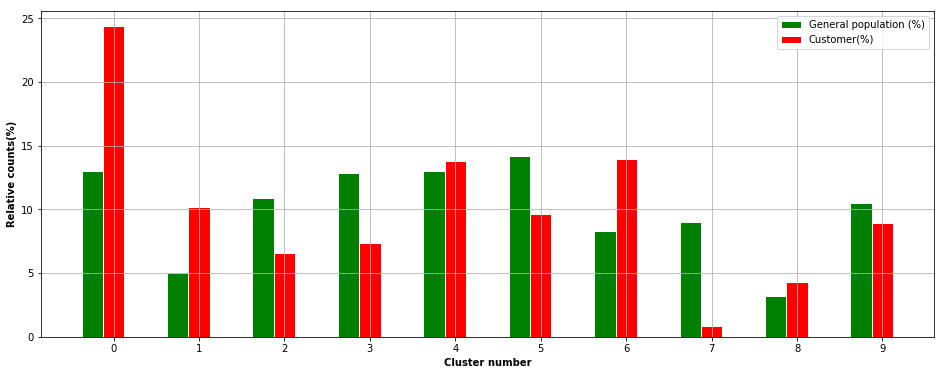

In [73]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#grouped bar plot (tewaked version from https://python-graph-gallery.com/11-grouped-barplot/)

fig = plt.figure(figsize=(16,6))

# set width of bar
barWidth = 0.25

# set height of bar
bars1 = df.genPopPcnt
bars2 = df.custPcnt


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color='Green', width=barWidth, edgecolor='white', label='General population (%)')
plt.bar(r2, bars2, color='red', width=barWidth, edgecolor='white', label='Customer(%)')

# Add xticks on the middle of the group bars
plt.xlabel('Cluster number', fontweight='bold')
plt.ylabel('Relative counts(%)', fontweight='bold')

plt.xticks([r + barWidth for r in range(len(bars1))], ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.grid(True)
# Create legend & Show graphic
plt.legend()

From the above graph, as an example

- cluster 0, cluster 6 are over represented in the customer data compared to general population
- cluster 7, cluster 3 are under represented represented in the customer data compared to general population

In [74]:
#define a function which evaluates the principal components and the
#provide us with the top ingradients for a given cluster
def analyseCluster(clusterval,pca):
    column_names=customer_imputedScaled_df.columns
    c= kmeans10.cluster_centers_[clusterval] #cordinates of cluster centers
    c = pd.Series(c)
    c.index = c.index +1
    print( "The principal components and the weights of cluster {} are: ".format(clusterval))
    c_sorted=c.sort_values(ascending=False)
    print( c_sorted )
    #----------------------------------
    #get the top PC  based on weight for further analysis
    #customer_imputedScaledPCA_df
    topPrincipalValue=c_sorted.index[0] 
    print("\n====> The top most principal value is :", topPrincipalValue)
    #----------------------------------
    #Transform clusterval to original feature values.
    afterInverse = scaler.inverse_transform(pca.inverse_transform(c))
    afterInverse = pd.Series(afterInverse)
    afterInverse.index = column_names
    print( "\n==========================The original feature values==================== \n ")
    print( afterInverse )
    #-----------------------------------------------------------------
    #print out the top and bottom 5 feature values 
    # in the prominent principal component  identified above  
    componentNumber=topPrincipalValue
    analysePrincipalComponents(pca, componentNumber, 5, column_names)    

### First let us analyse cluster 0  and 6 (with over-representation in customer segment)

In [75]:
#cluster 0
analyseCluster(0,pca)

The principal components and the weights of cluster 0 are: 
1     7.410778
6     0.200197
11    0.055593
14    0.042628
24    0.031952
10    0.031775
16    0.026784
20    0.025429
9     0.021768
15    0.021525
18    0.019130
25    0.012139
23    0.011962
30    0.000808
26   -0.001152
27   -0.002381
8    -0.002572
29   -0.004869
28   -0.008540
22   -0.015218
12   -0.020493
7    -0.027191
21   -0.048125
19   -0.048956
17   -0.052796
13   -0.096992
2    -0.183263
5    -0.269988
4    -0.440904
3    -0.483596
dtype: float64

====> The top most principal value is : 1

==========================The original feature values==================== 
 
ALTERSKATEGORIE_GROB                 1.708268
ANREDE_KZ                            1.531933
FINANZ_MINIMALIST                    3.012022
FINANZ_SPARER                        3.962849
FINANZ_VORSORGER                     3.007418
FINANZ_ANLEGER                       4.960962
FINANZ_UNAUFFAELLIGER                4.965140
FINANZ_HAUSBAUER                

In [76]:
#cluster 6
analyseCluster(6,pca)

The principal components and the weights of cluster 6 are: 
5     1.640372
6     0.750336
19    0.333679
11    0.326670
10    0.307683
17    0.143367
24    0.110047
20    0.110019
13    0.088884
22    0.064334
28    0.058242
4     0.042912
26    0.040712
15    0.034866
12    0.031852
25    0.029595
27   -0.001260
23   -0.009191
30   -0.027889
29   -0.034050
14   -0.105138
18   -0.105890
16   -0.160730
21   -0.199825
9    -0.428440
7    -0.878861
8    -1.065469
3    -2.192627
2    -2.829893
1    -2.893939
dtype: float64

====> The top most principal value is : 5

==========================The original feature values==================== 
 
ALTERSKATEGORIE_GROB                 3.527337
ANREDE_KZ                            1.224404
FINANZ_MINIMALIST                    4.808266
FINANZ_SPARER                        1.344710
FINANZ_VORSORGER                     4.624655
FINANZ_ANLEGER                       1.448953
FINANZ_UNAUFFAELLIGER                1.915054
FINANZ_HAUSBAUER                

### Now let us focus on  cluster 7  and 3 (with under-representation in customer segment)


In [77]:
#cluster 7
analyseCluster(7,pca)

The principal components and the weights of cluster 7 are: 
12    12.215572
14     5.430732
4      3.978195
10     2.354239
15     2.227815
9      1.810354
5      1.580726
3      1.154022
21     0.872862
20     0.527492
8      0.412681
19     0.335073
25     0.148716
27     0.140838
26     0.121006
28     0.109809
16     0.030671
29    -0.081121
13    -0.129075
22    -0.152063
30    -0.152679
24    -0.286448
2     -0.324094
18    -0.340983
7     -0.715131
23    -0.859099
1     -0.914326
17    -1.503231
6     -2.690189
11    -4.969688
dtype: float64

====> The top most principal value is : 12

==========================The original feature values==================== 
 
ALTERSKATEGORIE_GROB                 2.983146
ANREDE_KZ                            1.480208
FINANZ_MINIMALIST                    3.815480
FINANZ_SPARER                        2.523773
FINANZ_VORSORGER                     3.619578
FINANZ_ANLEGER                       2.861232
FINANZ_UNAUFFAELLIGER                2.805267
F

In [78]:
#cluster 3
analyseCluster(3,pca)

The principal components and the weights of cluster 3 are: 
2     4.862704
17    1.065882
6     0.355484
7     0.289056
14    0.273184
18    0.254663
19    0.203720
24    0.170298
4     0.156343
13    0.151047
8     0.136481
28    0.131108
30    0.104485
26    0.067740
20    0.028113
29   -0.043913
27   -0.096526
25   -0.160469
21   -0.168483
9    -0.221610
22   -0.290861
23   -0.442630
16   -0.522023
12   -0.523161
5    -0.611885
15   -0.769490
10   -0.819822
3    -1.390543
11   -2.103819
1    -2.504045
dtype: float64

====> The top most principal value is : 2

==========================The original feature values==================== 
 
ALTERSKATEGORIE_GROB                 3.543827
ANREDE_KZ                            1.303261
FINANZ_MINIMALIST                    3.579357
FINANZ_SPARER                        1.341614
FINANZ_VORSORGER                     4.650709
FINANZ_ANLEGER                       1.214695
FINANZ_UNAUFFAELLIGER                1.760435
FINANZ_HAUSBAUER                

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

- In order to understand the  segments better, we took the inverse transform of the top most principal component of the relevant clusters. Note that  (from  information deduced from the graph), compared to general population,  the customer data is over represented by clusters 0 and 6.  However, the customer data is under represented in  clusters 7 and 3.

So the company campaign should be targeted to the top most ingredients in cluster 0 and cluster 6, since this is the core customer base  for the company.

- Let us examine cluster 0; the biggest factors are in PC1 for cluster 0.The top most positive features in PC1 are : FINANZ_HAUSBAUER (home ownership),PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region),PLZ8_BAUMAX (Most common building type within the PLZ8 region), LP_STATUS_GROB_1.0 (low-income earners),CAMEO_INTL_2015_WEALTH (variable we encoded based on wealth/LifeStage). The top most negative features in PC1 are :FINANZ_MINIMALIST (low financial interest), PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region), KBA05_GBZ (Number of buildings in the microcell) KBA05_ANTG1 (Number of 1-2 family houses in the microcell),    MOBI_REGIO (Movement patterns)     

- Now look at cluster 6; the biggest factors comes from  PC5

- The top most positive features in PC5 are: LP_LEBENSPHASE_GROB (Life stage ); LP_FAMILIE_GROB_5.0  (multiperson household);  LP_LEBENSPHASE_FEIN  (finer scale of life stage);  ANZ_PERSONEN  (number of adults in household); LP_FAMILIE_FEIN_10.0 ( two-generational household). The top most negative features in PC5 are : PRAEGENDE_JUGENDJAHRE_MOVEMENT (dominating movement of person's youth),LP_STATUS_FEIN_10.0, LP_STATUS_GROB_5.0 ( both signifies top earners), LP_FAMILIE_GROB_1.0 , LP_FAMILIE_FEIN_1.0 (both single family) 

- Examination of cluster 7 reveals that the biggest factor comes from PC12. It mainly consists of  LP_STATUS_GROB_4.0 , LP_STATUS_FEIN_9.0 (both variable map to home owners), SEMIO_MAT (materialistic personality), MIN_GEBAEUDEJAHR, SHOPPER_TYP_1.0  (shopping-stressed) 

####  So in general,  the company is popular with low-income folks living in multi-person family arrangements with at least two generations. They tend to live in densely populated areas and likely live in apartments.  This seems to be the customer  base for the company and the campaign should target this segment. 

##### Also, it looks like company is not that popular with persons who owns a house, lives in a single family household and who are top earners and wealthy.

 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.